# Lesson 2

In the screencast for this lesson I go through a few scenarios for time series. This notebook contains the code for that with a few little extras! :)

# Setup

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
try:
  %tensorflow2.x
except:
  pass

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    '''
    Plot series of data

    Parameters
    ----------
    time : array of data
    series: array of data to plot in Y axis 
    format: format of basic line properties. Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
    start: from where to start plotting, optional. Default: 0
    end: up to where to plot data, optional. Default: None
    label: label to be set to the plot, optional. Default: None
    '''
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
        plt.grid(True)

# Trend and Seasonality

In [3]:
def trend(time, slope=0):
    '''
    Produce a trend of data.
    Parameters
    ---------- 
    time: time series to plot 
    slope: slope to plot the series. optional, Default: 0
    '''
    return time * slope

Let's create a time series that just trends upward:

In [6]:
# Return evenly spaced values for 1461 values
start_interval = 4 * 365 + 1
time = np.arange(start_interval)

assert len(time) == start_interval

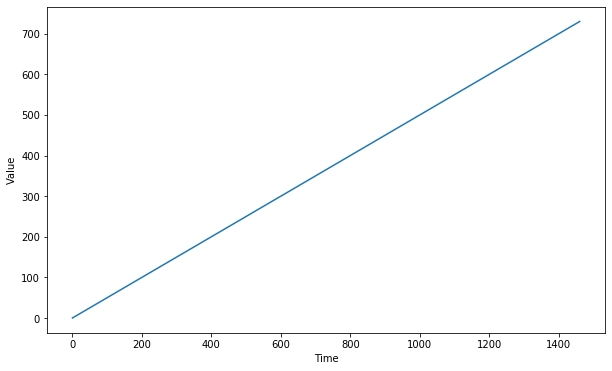

In [7]:
# produce the Ys for the time series plot 
slope_to_plot = 0.5
series = trend(time, slope_to_plot)

# Checkout how each point on the Y axis is half of the value on the X axis.
# this is because slope is set to 0.5 
assert time[0]/2 == series[0]
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's generate a time series with a seasonal pattern:

In [8]:
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern by using np.where
    Ref: https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html
    
    Parameters
    ----------
    season_time: to generate the condition of what to select from 
    """

    return np.where(season_time < 0.4, # condition 
                    np.cos(season_time * 2 * np.pi), # x: use Cosine element-wise.
                    1 / np.exp(3 * season_time)) # y: use 1/ exp * 3 season time



In [9]:
def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period
    Parameters
    ----------
    time: to generate the season over x axis 
    period: how often will repeat
    amplitude: how many phases
    phase: the position of the point in time
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

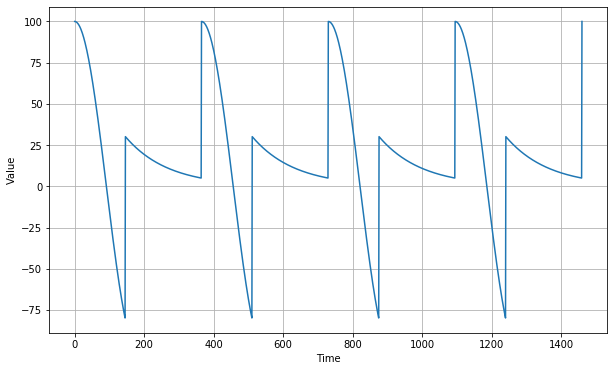

In [10]:
amplitude = 100
period = 365
phase = 0 
series = seasonality(time, period=period, amplitude=amplitude, phase=phase)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.grid(True)
plt.show()

Now let's create a time series with both trend and seasonality:

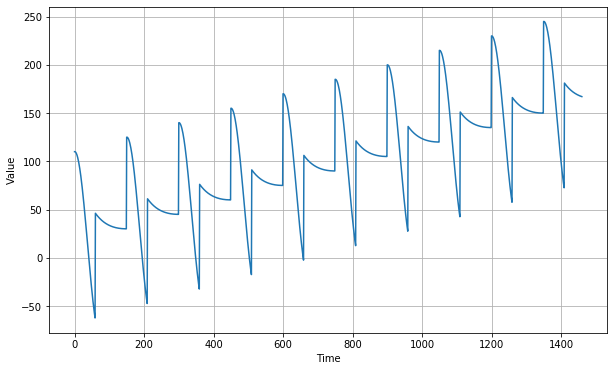

In [11]:
slope = 0.1
baseline = 10
period = 150
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.grid(True)
plt.show()

# Noise

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [4]:
def white_noise(time, noise_level=1, seed=None):
    '''
    Produce random noise into a time series 

    Parameters
    ----------
    time: series of values on X axis
    noise_level: to be produced, optional. Default: 1
    seed: seed to generate the noise, optional. Default: None 
    '''
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

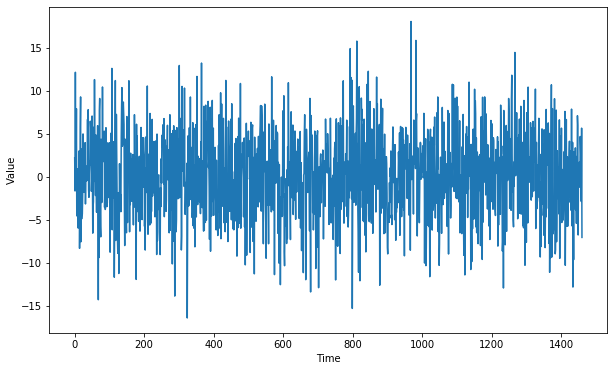

In [13]:
noise_level = 5
seed = 5
noise = white_noise(time, noise_level, seed)

# lets plot the noise produced 
plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Now let's add this white noise to the time series:

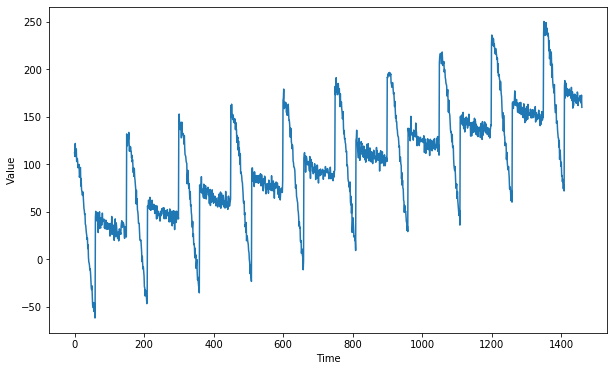

In [14]:
# Add the noise to the series
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000.

In [15]:
split_time = 1000
# split between training and validation
time_train, time_valid = time[:split_time], time[split_time:]
x_train, x_valid = series[:split_time], series[split_time:]

In [20]:
def autocorrelation(time, amplitude, seed=None):
    '''
    Produce Autocorrelation
  
    Parameters
      ----------
    time: series of values on X axis
    amplitude: the height of the oscilation to be produced
    seed: will initialize the random Generator, optional. Default: None 
    '''    
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    series = rnd.randn(len(time) + 50)
    series[:50] = 100
    for step in range(50, len(time) + 50):
        series[step] += φ1 * series[step - 50]
        series[step] += φ2 * series[step - 33]
    return series[50:] * amplitude

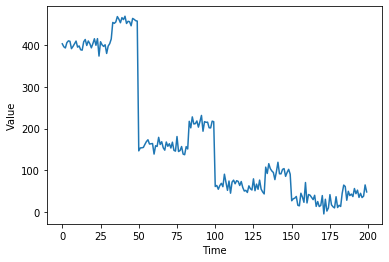

In [21]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

In [22]:
def autocorrelation(time, amplitude, seed=None):
    '''
    Produce Autocorrelation
  
    Parameters
      ----------
    time: series of values on X axis
    amplitude: the height of the oscilation to be produced
    seed: will initialize the random Generator, optional. Default: None 
    '''        
    rnd = np.random.RandomState(seed)
    φ = 0.8
    series = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        series[step] += φ * series[step - 1]
    return series[1:] * amplitude

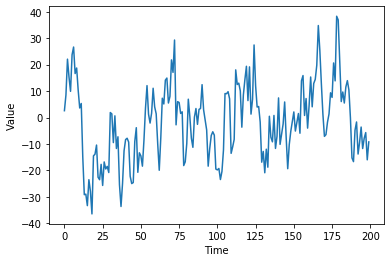

In [23]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

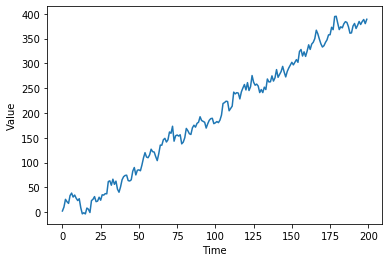

In [24]:
# Autocorrelation with Trend
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

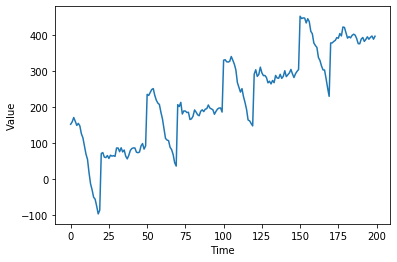

In [25]:
# Autocorrelation with Seasonality and Trend
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

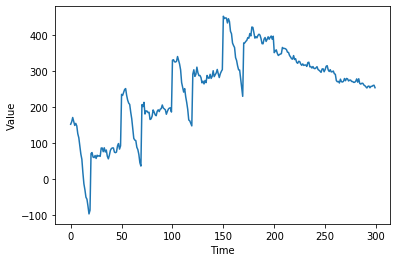

In [26]:
# Autocorrelation + Seasonality and Trend 
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
# Big change introduced around 200 time step
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [27]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    '''
    Generation of Impulses 
    
    Parameters
    ----------
    time: series of values on X axis
    num_impulses: size of impulse indices to be generated
    amplitude: the height of the oscilation to be produced
    seed: will initialize the random Generator, optional. Default: None 
    '''
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=num_impulses)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

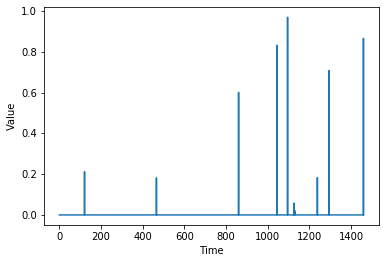

In [29]:
series = impulses(time, num_impulses=10, seed=42)
plot_series(time, series)
plt.show()

In [30]:
def autocorrelation(source, φs):
    '''
    Generate autocorrelation with lag
    
    Parameters
    ----------
    source: series of values on X axis
    φs: dictionary with lag and delta to be generated by lag
    
    Return: series of values with lag
    '''    
    series = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
                series[step] += φ * series[step - lag]
    return series

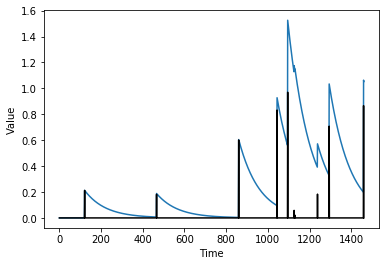

In [31]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

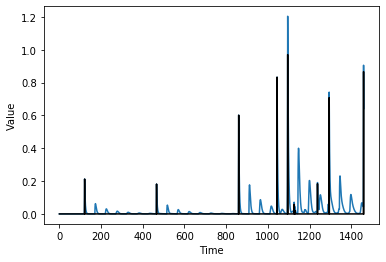

In [32]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

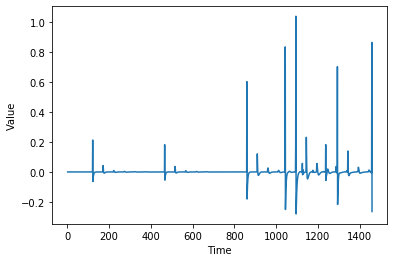

In [34]:
# Plot differencing 
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

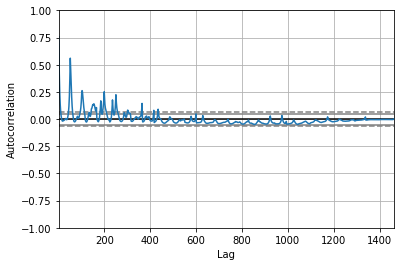

In [37]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [41]:
!sudo pip install statsmodels

     |████████████████████████████████| 8.1MB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 235kB 6.4MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [42]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Thu, 26 Dec 2019   AIC                          -4432.855
Time:                        19:51:56   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

## Additional Section with dataset that is not provided 

In [0]:
df = pd.read_csv("sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

In [0]:
series.plot(figsize=(12, 5))

In [0]:
series["1995-01-01":].plot()

In [0]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

In [0]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [0]:
autocorrelation_plot(series.diff(1)[1:])

In [0]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

In [0]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [0]:
116.7 - 104.3

In [0]:
[series.autocorr(lag) for lag in range(1, 50)]

In [0]:
pd.read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
Read a comma-separated values (csv) file into DataFrame.


In [0]:
from pandas.plotting import autocorrelation_plot

series_diff = series
for lag in range(50):
    series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

In [0]:
import pandas as pd

series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()